# Wavelet Features For Speech Recognition.

I've been partipating in the TensorFlow speech recognition challenge.  

https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

It seems like the most common approach is to begin by turning the audio into a spectrogram and then feeding that into a 2D CNN. One trouble with spectrograms is that you have to trade off resolution in frequency for resolution in time and vice versa. In principle you can get higher resolution in time for higher frequencies than you can for lower frequencies but when you pick an input length for your short time fourier transform you lose temporal resolution much below the window length. 

Wavelets are one possible way around this limitation <!-- TEASER_END -->  and I thought it would be fun to see what sort of performance I could get out of a network which uses wavelet based features as inputs. A wavelet is a function which looks like a "wiggle" that is it starts out zero oscilates a couple times and becomes zero again. Technically that isn't quite enough to make a function qualify as a wavelet but for our purposes here it is good enough. If you are interested there is quite a bit of material on the web about wavelets.

https://en.wikipedia.org/wiki/Wavelet

In practice the way wavelets tend to be used is as a convenient set of low pass and high pass filters which can be iteratively applied to a signal followed by downsampling operations to generate a set of multi-scale representations of the original data. Using the handy pywavelets package we can fetch the filter coefficients for our favorite wavelet and use it as a convolution kernel in a series of convolution layers.

In [1]:
import os
import copy

import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

import keras
import keras.backend as K
import tensorflow as tf

import IPython.display as ipd

from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, LeakyReLU, concatenate

Using TensorFlow backend.


In [2]:
%matplotlib inline

Text(0.5,0,'Frequency')

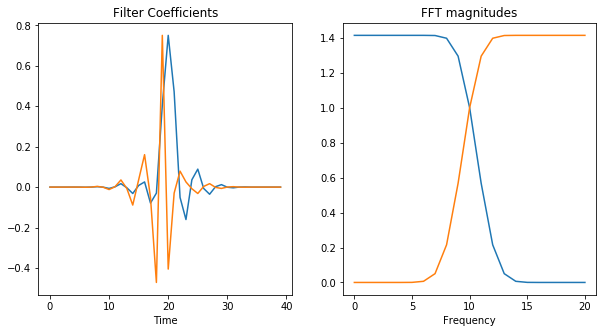

In [3]:
import pywt

low_pass, high_pass  = pywt.Wavelet("sym20").filter_bank[:2]
low_pass = np.array(low_pass)
high_pass = np.array(high_pass)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(low_pass)
axes[0].plot(high_pass)

axes[1].plot(np.abs(np.fft.rfft(low_pass)))
axes[1].plot(np.abs(np.fft.rfft(high_pass)))
axes[0].set_title("Filter Coefficients")
axes[1].set_title("FFT magnitudes")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Frequency")

Since convolution is multiplication in the fourier domain applying the low pass filter keeps the lower half of the frequencies and the high pass filter keeps the upper half. Because we are using what is called a "perfect reconstruction wavelet" the filters are also designed such that we don't lose any information by downsampling by 2 after convolution. 

Lets translate that formula into something suitable for use in tensorflow. 

In [4]:
def make_wavelet_expansion(
    input_tensor, 
    n_levels,
    low_pass_filter,
    high_pass_filter,
    trainable=False,
):
    wv_kwargs = {
        "filters":1,
        "kernel_size":len(low_pass),
        "strides":2,     
        "use_bias":False, 
        "padding":"same", 
        "trainable":trainable,
    }
    
    approximation_coefficients = []
    detail_coefficients = []
    
    last_approximant = input_tensor
    for i in range(n_levels):
        lpf = low_pass_filter
        hpf = high_pass_filter
        a_n = Conv1D(
            kernel_initializer=keras.initializers.Constant(lpf.reshape((-1, 1))),
            name="low_pass_{}".format(i),
            **wv_kwargs
        )(last_approximant)
        d_n = Conv1D(
            kernel_initializer=keras.initializers.Constant(hpf.reshape((-1, 1))),
            name="high_pass_{}".format(i),
            **wv_kwargs,
        )(last_approximant)
        
        detail_coefficients.append(d_n)
        approximation_coefficients.append(a_n)
        last_approximant = a_n
    
    return approximation_coefficients, detail_coefficients
    

This function takes an input tensor with just one channel and passes it through the high pass and low pass filters. The result of applying the low pass filter just smooths the data a little and so the result is called the "approximation coefficients". The high pass filter effectively gives the residuals of the original data minus the smoothed data and so these are the "detail coefficients". Both of these vectors would carry redundant information if we kept every pixel of the convolution and so by the design of the wavelet filters we can keep only every other point or equivalently use a convolution which is strided by 2.

The frequencies in the detail coefficients are high enough that 2 pixels is just about enough to localize an oscilation of that frequency in time while also still giving us a good idea as to the magnitude of that oscillation. The approximation coefficients are a different story. For the frequencies close to the low pass cut off we could almost estimate the magnitude of an oscillation from just one or two coefficients but for lower frequencies we would need more and more. A good way to handle this is to simply repeat the previous application of low and high pass filters again. The detail coefficients again contain only information which is close to the right frequency so that individual pixels (after the downsampling/striding) still carry significant magnitude information while also being about as localized in time as is possible for that frequency. By continuing this process some number of steps we get a typical wavelet expansion.

Because wavelets (like ffts) like to operate on vectors which are powers of 2 so that everything works out nicely we will zero pad our audio inputs to be 16,384 points long and do an 8 level wavelet expansion. Since we are doing this all inside of TensorFlow we might as well make the wavelet filters trainable while we are at it.

In [5]:
input_length = 16000
target_length = 16384

sound_in = keras.layers.Input(shape=(target_length, 1), name="audio")

wavelets_trainable = True

approx_stack, detail_stack = make_wavelet_expansion(
    sound_in, 
    n_levels = 9, 
    low_pass_filter=low_pass, 
    high_pass_filter=high_pass,
    trainable=wavelets_trainable,
)

The detail coefficients at every level represent independent information from each other but the approximation coefficients are just successively smoothed versions of the input signal. The very last approximation tensor in our stack represents information that hasn't been captured by any of the detail coefficients however and so should be included in our feature set.

In [6]:
features_list = []
features_list.extend(detail_stack)
features_list.append(approx_stack[-1])

features_list

[<tf.Tensor 'high_pass_0/convolution/Squeeze:0' shape=(?, 8192, 1) dtype=float32>,
 <tf.Tensor 'high_pass_1/convolution/Squeeze:0' shape=(?, 4096, 1) dtype=float32>,
 <tf.Tensor 'high_pass_2/convolution/Squeeze:0' shape=(?, 2048, 1) dtype=float32>,
 <tf.Tensor 'high_pass_3/convolution/Squeeze:0' shape=(?, 1024, 1) dtype=float32>,
 <tf.Tensor 'high_pass_4/convolution/Squeeze:0' shape=(?, 512, 1) dtype=float32>,
 <tf.Tensor 'high_pass_5/convolution/Squeeze:0' shape=(?, 256, 1) dtype=float32>,
 <tf.Tensor 'high_pass_6/convolution/Squeeze:0' shape=(?, 128, 1) dtype=float32>,
 <tf.Tensor 'high_pass_7/convolution/Squeeze:0' shape=(?, 64, 1) dtype=float32>,
 <tf.Tensor 'high_pass_8/convolution/Squeeze:0' shape=(?, 32, 1) dtype=float32>,
 <tf.Tensor 'low_pass_8/convolution/Squeeze:0' shape=(?, 32, 1) dtype=float32>]

Unlike the convenience of the STFT however these wavelet features are all different lengths. It would be nice to have a rectangular image representation just like what we get out of a short time fourier transform. We can resize each of these wavelet features to some standard length by either upsampling or averaging. Picking the lowest frequency features and averaging all the others down to that scale would lose us too much temporal information. Meanwhile upsampling all these features back up to the maximum length one would be an awful lot of unnecessary redundancy and probably an unnecessary amount of temporal resolution too. 

We pick a mid ground somewhere inbetween and upsample the shorter vectors and average the longer vectors so that the all match and then concatenate the vectors together. If we square the magnitudes before we do the averaging then we effectively get a wavelet "spectrogram". 

In [7]:
target_size = 256
min_pool_size = 3

def press_tensor(
    input_tensor, 
    target_length, 
    min_pool_size,
    pooling_type="average",
):
    """Resize a tensor to a desired shape by upsampling or averaging (or some combination)"""
    cur_size = int(input_tensor.shape[1])
    if cur_size < target_length:
        input_tensor = keras.layers.UpSampling1D(target_length//cur_size)(input_tensor)
    size_ratio = max(1, cur_size//target_length)
    pool_size = max(min_pool_size, size_ratio)
    if not (pool_size == 1 and size_ratio == 1):
        return keras.layers.AveragePooling1D(pool_size=pool_size, strides=size_ratio, padding="same")(input_tensor)
    else:
        return input_tensor

resized_features = []

for wv_in in features_list:
    x = keras.layers.BatchNormalization()(wv_in)#normalize each filter before taking the power
    x = keras.layers.Lambda(lambda x: tf.square(x))(x)#square the coefficients to get a power estimate
    resized_features.append(press_tensor(x, target_size, min_pool_size))

#concatenate the features together to get our spectrogram
specgram = keras.layers.concatenate(resized_features)
log_specgram = keras.layers.Lambda(lambda x: tf.log(1.0+x))(specgram)

specgram_model = keras.models.Model(sound_in, log_specgram)

Now to load in some helpers from a python helper module I wrote for the competition (It will likely show up on github after the competition is over).

In [8]:
import tf_speech_recognition as tsr

command_words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

command_encoder = tsr.preprocessing.LimitedVocabularyEncoder(
    vocabulary=command_words,
    encoding_type="onehot",
)

target_labels = copy.copy(command_words)
target_labels = target_labels + ["silence", "unknown"]

random_labeler = tsr.preprocessing.RandomLabeler(field="word", labels=target_labels)

preprocessor = tsr.SoundPreprocessor(
    input_transforms={"audio":lambda x, y: x.reshape((-1, 1))},
    output_transforms={
        "command_probs":lambda x, y: command_encoder.encode(x["word"]),
    },
    input_length=input_length,
    target_length=target_length,
    downsampling_rate=1,
    t_shift_max=200,
    silence_fraction=0.1,
    additive_bg_fraction=0.4,
    bg_mag_range=(0.01, 0.25),
    relabel_fraction=0.0,
    bg_noise_samples=tsr.get_background_noise_samples(),
    mean_subtract=True,
    norm_type="rms",
    norm_damp=1e-4,
)

load_batch = tsr.data_loading.simple_sound_batch_loader

train_labels = tsr.get_labels_df("train")

train_loading_kwargs = dict(
    labels_df=train_labels,
    preprocessor=preprocessor,
    augment=True,
    data_directory=os.path.join(tsr.data_dir, "raw", "train", "audio"),
    forcing_kwargs={},
)

/home/tim/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


# Example Wavelet 'Spectrograms'

The resulting "spectrograms" look quite different from the regulr STFT spectrograms. This is mostly due to the very coarse frequency information. Since we are simply averaging the square magnitude for every wavelet feature we are lumping together all frequencies within a factor of 2 of each other into the same band. I have experimented with breaking these out into sub-bands either by applying a "tree" of wavelet filters by putting the longer detail coefficient vectors through their own wavelet expansion before concatenating them together but the simple 10 frequency band features from doing just one expansion works surprisingly well. 

word= off


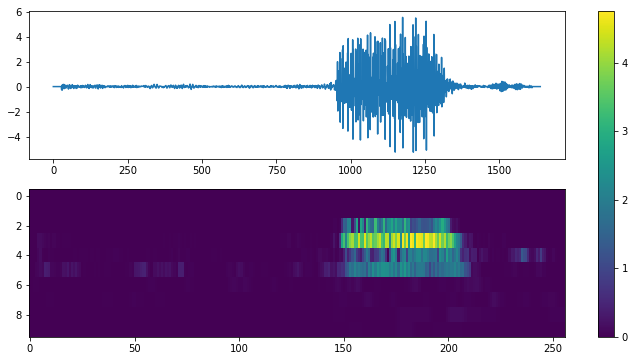

word= off


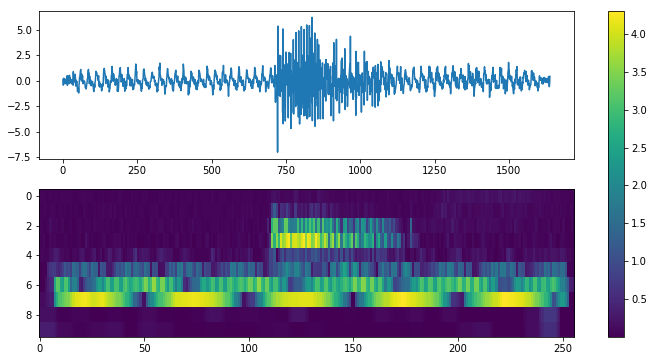

word= off


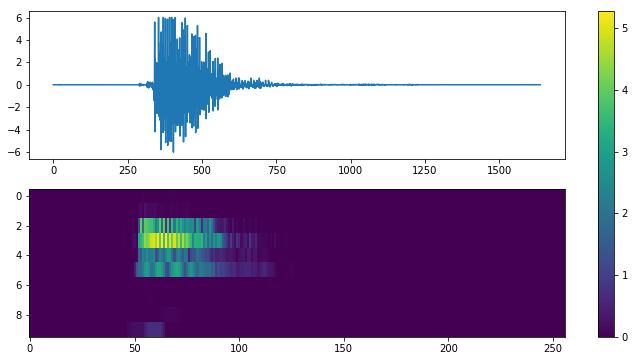

word= off


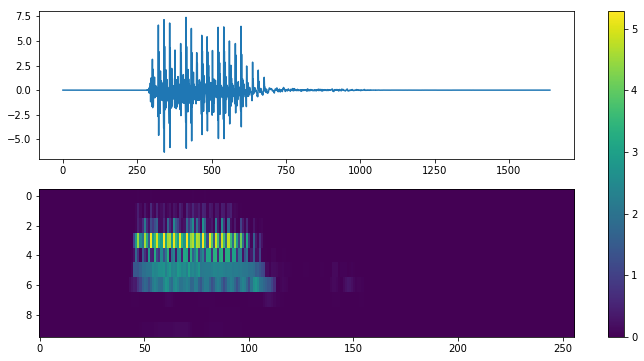

word= off


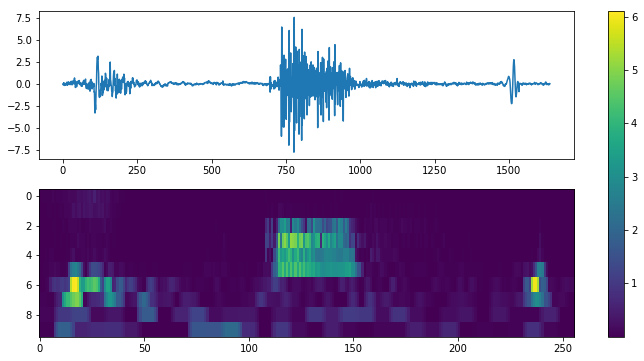

word= off


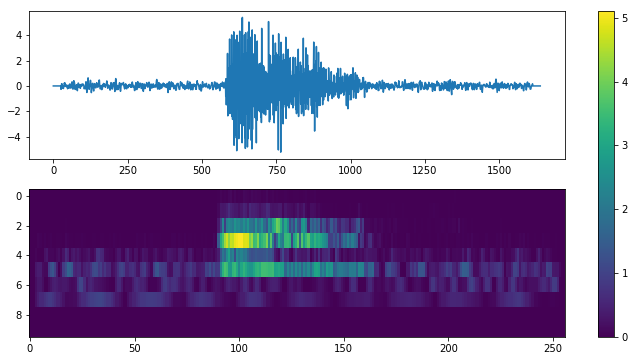

word= off


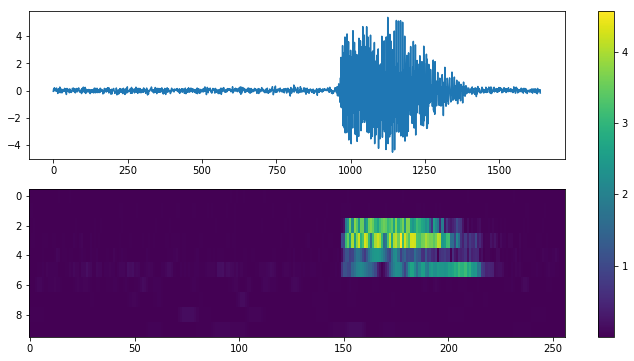

word= off


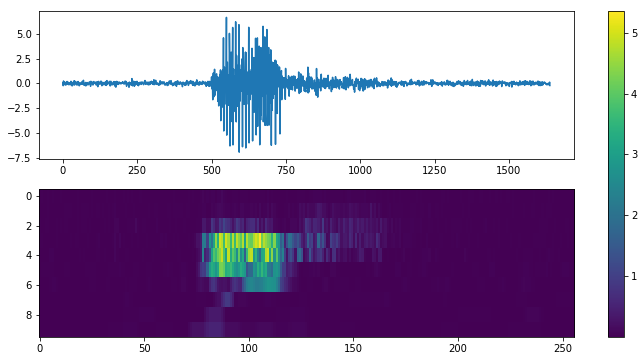

word= off


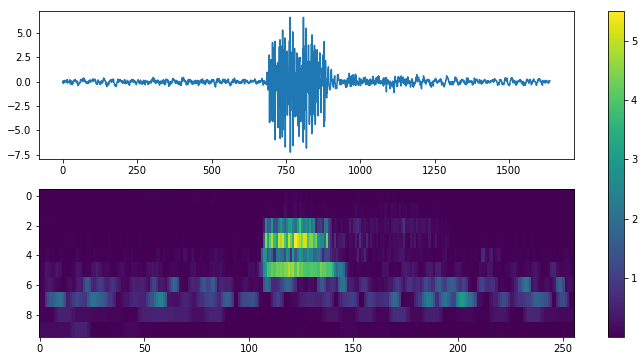

word= off


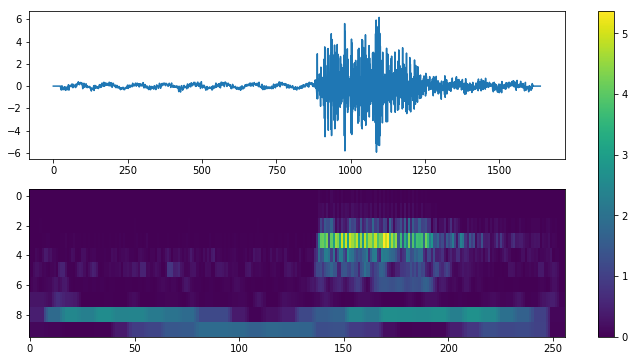

In [9]:
example_batch = load_batch(train_labels.index[:10], **train_loading_kwargs)

spec_out = specgram_model.predict(example_batch[0])

for b_i in range(len(example_batch[0]["audio"])):
    print("word=", command_encoder.decode(example_batch[1]["command_probs"][b_i]))
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    axes[0].plot(example_batch[0]["audio"][b_i, ::10, :])
    im = axes[1].imshow(spec_out[b_i].transpose(), aspect="auto")
    plt.colorbar(im, ax=list(axes))
    plt.show()

# Wavelet Spectrogram Based Model

Now to make a network architecture to turn these wavelet features into command predictions. Just 10 frequency channels seems a waste of a 2D CNN and so I will settle for a 1D CNN with 10 input channels. I use length 9 filters and doubling the number of filters with each layer and halving the temporal resolution until I hit a total timewise dimension of just 16 at which point a single length 9 convolution covers over half of the full input and should be sufficient to classify a word. Then I take the global max pool and feed that into a dense layer.

In [10]:
def make_conv(
        x,
        n_filters,
        kernel_size,
        conv_strides,
        leak,
        pool_size,
        pool_strides,
        conv_kwargs=None,
):
    n_dim = len(x.shape)-1
    if n_dim == 2:
        conv = Conv1D
        pool = MaxPooling1D
    elif n_dim == 3:
        conv = Conv2D
        pool = MaxPooling2D
    else:
        raise ValueError()
    
    if conv_kwargs is None:
        conv_kwargs={}
    x = conv(
        n_filters, 
        kernel_size=kernel_size,
        strides=conv_strides,
        padding="same",
        activation=None,
        **conv_kwargs
    )(x)
    if not pool_size is None:
        x = pool(
            pool_size=pool_size,
            strides=pool_strides,
            padding="same",
        )(x)
    else:
        assert pool_strides is None
    x = LeakyReLU(alpha=leak)(x)
    return x

In [11]:
#power conv stack
x = specgram
x = make_conv(x, 16,  9,  1, 0.2, 2, 2)
x = make_conv(x, 32, 9, 1, 0.2, 2, 2)
x = make_conv(x, 64, 9, 1, 0.2, 2, 2)
x = make_conv(x, 128, 9, 1, 0.2, 2, 2)
x = make_conv(x, 256, 9, 1, 0.2, 2, 2)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(100)(x)
x = LeakyReLU(alpha=0.2)(x)

command_probs = keras.layers.Dense(12, activation="softmax", name="command_probs")(x)

model = keras.models.Model(sound_in, command_probs)

In [12]:
def damped_log_loss(y_true, y_pred):
    damp_param = 0.0001
    clipped = (y_pred+damp_param)/(1.0+2.0*damp_param)
    costs = -1.0*(y_true*K.log(clipped) + (1.0-y_true)*K.log(1.0-clipped))
    return K.mean(costs)

In [13]:
optimizer = keras.optimizers.Adam()
model.compile(loss=damped_log_loss, optimizer=optimizer)

In [14]:
dev_labels = tsr.get_labels_df("dev")

dev_loading_kwargs = dict(
    labels_df=dev_labels,
    preprocessor=preprocessor,
    augment=False,
    data_directory=os.path.join(tsr.data_dir, "raw", "train", "audio"),
    forcing_kwargs={},
)

In [15]:
import sklearn.metrics
import itertools
from tf_speech_recognition.visualization import plot_confusion_matrix

def evaluate_command_model_quality(
    command_model,
    show_plot=True,
):
    dev_true = []
    dev_pred = []
    
    for i in range(len(dev_labels)//batch_size):
        xi, yi, aug_dict = load_batch(
            dev_labels.index[i*batch_size:(i+1)*batch_size], 
            **dev_loading_kwargs,
        )
        pred_res = command_model.predict(xi)
        pred_yi = pred_res#np.hstack([pred_res[1][:, :11], np.sum(pred_res[1][:, 11:], axis=1, keepdims=True)]) 
        dev_true.append(np.argmax(yi["command_probs"], axis=1))
        dev_pred.append(np.argmax(pred_yi, axis=1))
    
    dev_true = np.hstack(dev_true)
    dev_pred = np.hstack(dev_pred)
    
    mean_acc = np.mean(dev_true==dev_pred)
    print("mean accuracy", mean_acc)
    if show_plot:
        conf_mat = sklearn.metrics.confusion_matrix(dev_true, dev_pred, labels=np.arange(12))
        fig, ax = plt.subplots(figsize=(12, 6))
        plot_confusion_matrix(
            conf_mat, 
            classes=target_labels,
            normalize=True,
            title='Confusion matrix',
            cmap=plt.cm.Blues,
            ax=ax,
        )
        plt.show()

beginning training

 epoch 1
0.33644 0.17501 0.12962 0.10146 

0.71 minutes per epoch
mean accuracy 0.758263221154

 epoch 2
0.08425 0.07176 0.06800 0.06435 

0.67 minutes per epoch
mean accuracy 0.829326923077

 epoch 3
0.05954 0.05407 0.05088 0.04952 

0.67 minutes per epoch
mean accuracy 0.860276442308

 epoch 4
0.04700 0.04443 0.04369 0.04322 

0.67 minutes per epoch
mean accuracy 0.869441105769

 epoch 5
0.04233 0.03937 0.03794 0.03863 

0.67 minutes per epoch
mean accuracy 0.883563701923
Normalized confusion matrix


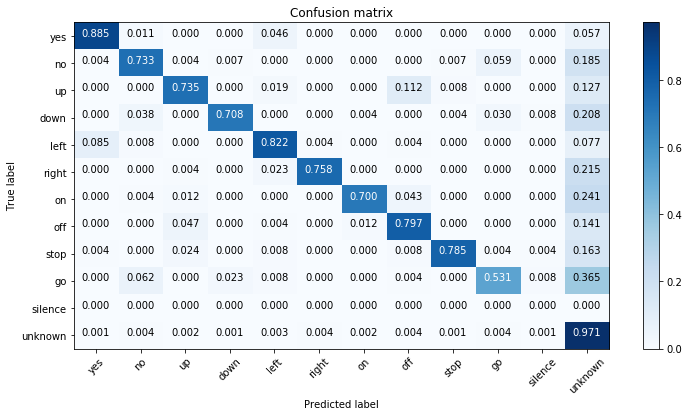


 epoch 6
0.03464 0.03344 0.03423 0.03423 

0.65 minutes per epoch
mean accuracy 0.897385817308

 epoch 7
0.03338 0.03145 0.03045 0.03123 

0.65 minutes per epoch
mean accuracy 0.889423076923

 epoch 8
0.03181 0.02864 0.02826 0.02888 

0.65 minutes per epoch
mean accuracy 0.90625

 epoch 9
0.02700 0.02764 0.02694 0.02615 

0.65 minutes per epoch
mean accuracy 0.90234375

 epoch 10
0.02804 0.02334 0.02541 0.02550 

0.65 minutes per epoch
mean accuracy 0.913010817308
Normalized confusion matrix


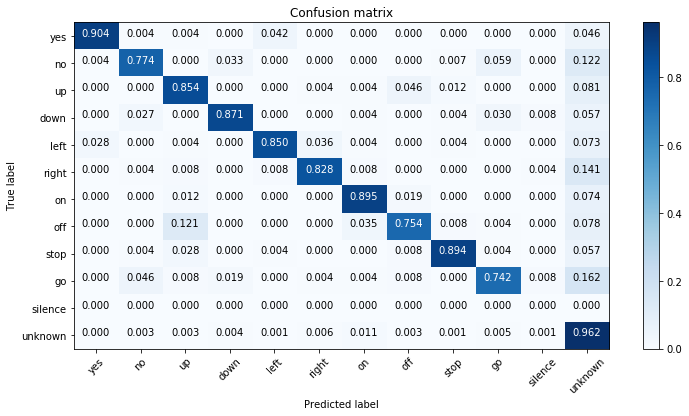

In [16]:
train_losses = []
model_quality_results = []

def do_training_iteration(): 
    train_hashes = train_batcher.make_batch(batch_size)
    xi, yi, aug_dict = load_batch(
        train_hashes, 
        **train_loading_kwargs,
    )
    ctime = time.time()
    yres = model.train_on_batch(xi, yi)
    train_losses.append(yres)

batch_size = 256
batches_per_epoch = len(train_labels)//batch_size + 1

train_batcher = tsr.data_loading.BalancedBatcher([train_labels.index,])

print("beginning training")
plot_frequency = 5

for epoch_idx in range(10):
    stime = time.time()
        
    print("\n epoch", epoch_idx+1)
    for iter_idx in range(batches_per_epoch):
        do_training_iteration()
        if (iter_idx % 50) == 0:
            print("{:4.5f} ".format(np.mean(train_losses[-50:])), end="")
    print("\n")
    etime = time.time()
    print("{:4.2f} minutes per epoch".format((etime-stime)/60.0))
    show_plot = (epoch_idx % plot_frequency) == plot_frequency-1
    mq_res = evaluate_command_model_quality(
        command_model=model, 
        show_plot=show_plot
    )
    model_quality_results.append(mq_res)

While the accuracy of the resulting model is nothing spectacular it certainly demonstrates that the wavelet based features have significant power in terms of recognizing the desired target words. This is particularly impressive considering the extremely coarse frequency resolution of the input bands. I have experimented with breaking the wavelet features up into sub-bands in various ways and I do indeed get some performance improvements but not as much as I might have naively expected.

# Custom Wavelet Filters

Since we let the wavelet filters float as trainable parameters we should take a moment to see what the wavelet filters ultimately ended up looking like after a few training epochs.

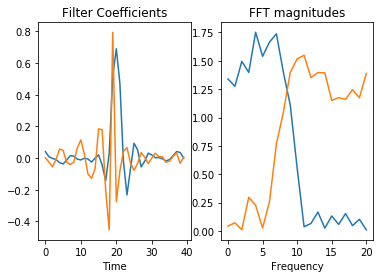

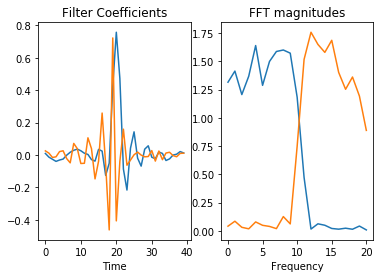

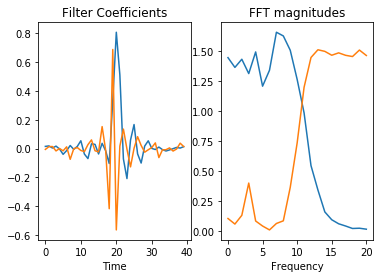

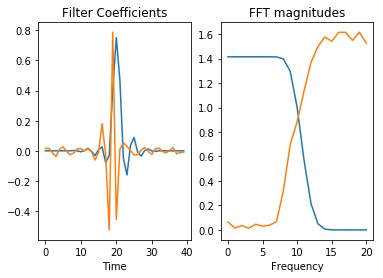

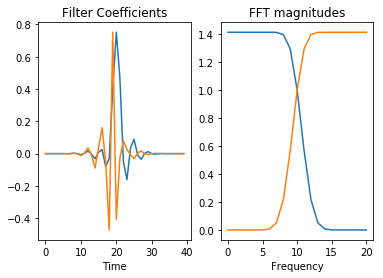

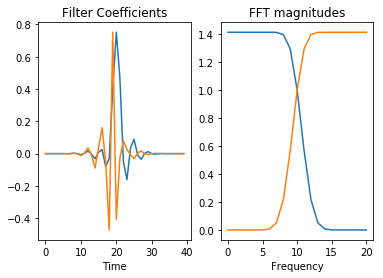

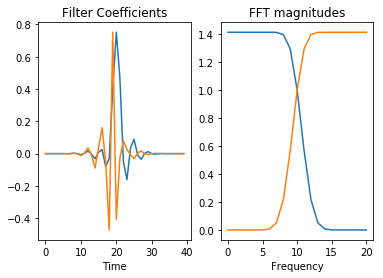

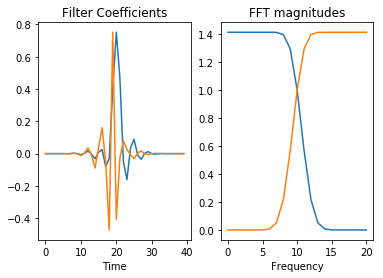

In [18]:
for i in range(1, 9):
    lpv = K.get_value(model.get_layer("low_pass_{}".format(i)).kernel)[:, 0, 0]
    hpv = K.get_value(model.get_layer("high_pass_{}".format(i)).kernel)[:, 0, 0]
    
    fig, axes = plt.subplots(1, 2)
    
    ax = axes[0]
    ax.plot(lpv)
    ax.plot(hpv)
    
    ax = axes[1]
    ax.plot(np.abs(np.fft.rfft(lpv)))
    ax.plot(np.abs(np.fft.rfft(hpv)))
    axes[0].set_title("Filter Coefficients")
    axes[1].set_title("FFT magnitudes")
    axes[0].set_xlabel("Time")
    axes[1].set_xlabel("Frequency")
    
    plt.show()

The wavelet filters surprisingly change very little with the filters deeper in the network changing less and less. In fact the filters change so little it makes me suspicious that my network is somehow suffering from poor normalization or poorly chosen learning rates. However it also makes sense that the orthogonality of the initial wavelet filters would make a potential well too deep for the network to escape. 

It is tempting to add small amounts of noise to the starting filter coefficients to see whether or not they tend to relax back towards the perfect reconstruction filters. 